# **NYC Taxi trip duration**

## Imports

In [7]:
import pandas as pd
import matplotlib
import pydot
import re
import datetime

%matplotlib inline
import matplotlib
import matplotlib.pyplot as plt
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['xtick.labelsize'] = 12
plt.rcParams['ytick.labelsize'] = 12

import numpy as np
import sklearn
import seaborn as sns

# Ignore warnings
import warnings
warnings.filterwarnings('ignore')

from sklearn import metrics
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor 
from sklearn.svm import SVC  
from sklearn.preprocessing import StandardScaler
from sklearn.tree import export_graphviz, DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB, MultinomialNB
from sklearn.feature_extraction import DictVectorizer
from sklearn.decomposition import PCA

import os
os.environ['KMP_DUPLICATE_LIB_OK']='True'
from xgboost import XGBRegressor

from IPython.display import display

# Functions

In [8]:
# Create table for missing data analysis
def draw_missing_data_table(df):
    total = df.isnull().sum().sort_values(ascending=False)
    percent = (df.isnull().sum()/df.isnull().count()).sort_values(ascending=False)
    missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
    return missing_data

# vectorized error calc
def rmsle(y, y0):
    assert len(y) == len(y0)
    return np.sqrt(np.mean(np.power(np.log1p(y)-np.log1p(y0), 2)))

# Data

In [9]:
#path of datasets
path_train = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'datasets/train.csv')
path_test = os.path.join(os.path.dirname(os.path.abspath('__file__')), 'datasets/test.csv')

In [10]:
#create dataframe for training dataset and print ten first rows as preview
test_df_raw = pd.read_csv(path_test)
test_df_raw.head()

,id,vendor_id,pickup_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag
0,id3004672,1,2016-06-30 23:59:58,1,-73.988129,40.732029,-73.990173,40.756680,N
1,id3505355,1,2016-06-30 23:59:53,1,-73.964203,40.679993,-73.959808,40.655403,N
2,id1217141,1,2016-06-30 23:59:47,1,-73.997437,40.737583,-73.986160,40.729523,N
3,id2150126,2,2016-06-30 23:59:41,1,-73.956070,40.771900,-73.986427,40.730469,N
4,id1598245,1,2016-06-30 23:59:33,1,-73.970215,40.761475,-73.961510,40.755890,N


In [11]:
test_df_raw.shape

(625134, 9)

## 1. EDA

In [12]:
#create dataframe for training dataset and print ten first rows as preview
train_df_raw = pd.read_csv(path_train)
train_df_raw.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982155,40.767937,-73.964630,40.765602,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980415,40.738564,-73.999481,40.731152,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979027,40.763939,-74.005333,40.710087,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010040,40.719971,-74.012268,40.706718,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973053,40.793209,-73.972923,40.782520,N,435


In [13]:
train_df_raw['store_and_fwd_flag'].value_counts()

N    1450599
Y       8045
Name: store_and_fwd_flag, dtype: int64

In [14]:
# Compute some basical statistics on the dataset
train_df_raw.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06,1.458644e+06
mean,1.534950e+00,1.664530e+00,-7.397349e+01,4.075092e+01,-7.397342e+01,4.075180e+01,9.594923e+02
std,4.987772e-01,1.314242e+00,7.090186e-02,3.288119e-02,7.064327e-02,3.589056e-02,5.237432e+03
min,1.000000e+00,0.000000e+00,-1.219333e+02,3.435970e+01,-1.219333e+02,3.218114e+01,1.000000e+00
25%,1.000000e+00,1.000000e+00,-7.399187e+01,4.073735e+01,-7.399133e+01,4.073588e+01,3.970000e+02
50%,2.000000e+00,1.000000e+00,-7.398174e+01,4.075410e+01,-7.397975e+01,4.075452e+01,6.620000e+02
75%,2.000000e+00,2.000000e+00,-7.396733e+01,4.076836e+01,-7.396301e+01,4.076981e+01,1.075000e+03
max,2.000000e+00,9.000000e+00,-6.133553e+01,5.188108e+01,-6.133553e+01,4.392103e+01,3.526282e+06


In [15]:
draw_missing_data_table(train_df_raw)

,Total,Percent
trip_duration,0,0.0
store_and_fwd_flag,0,0.0
dropoff_latitude,0,0.0
dropoff_longitude,0,0.0
pickup_latitude,0,0.0
pickup_longitude,0,0.0
passenger_count,0,0.0
dropoff_datetime,0,0.0
pickup_datetime,0,0.0
vendor_id,0,0.0


In [16]:
train_df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


In [17]:
# Delete trip which duration exeeds 2 hours and location outside NYC
train_df_eda = train_df_raw.copy()
train_df_eda = train_df_eda[train_df_raw['trip_duration'] < 7200]
train_df_eda = train_df_eda[train_df_raw['pickup_longitude'] > -74.258]
train_df_eda = train_df_eda[train_df_raw['pickup_longitude'] < -73.695]
train_df_eda = train_df_eda[train_df_raw['dropoff_longitude'] > -74.258]
train_df_eda = train_df_eda[train_df_raw['dropoff_longitude'] < -73.695]
train_df_eda = train_df_eda[train_df_raw['pickup_latitude'] < 40.921]
train_df_eda = train_df_eda[train_df_raw['pickup_latitude'] > 40.500]
train_df_eda = train_df_eda[train_df_raw['dropoff_latitude'] < 40.921]
train_df_eda = train_df_eda[train_df_raw['dropoff_latitude'] > 40.500]

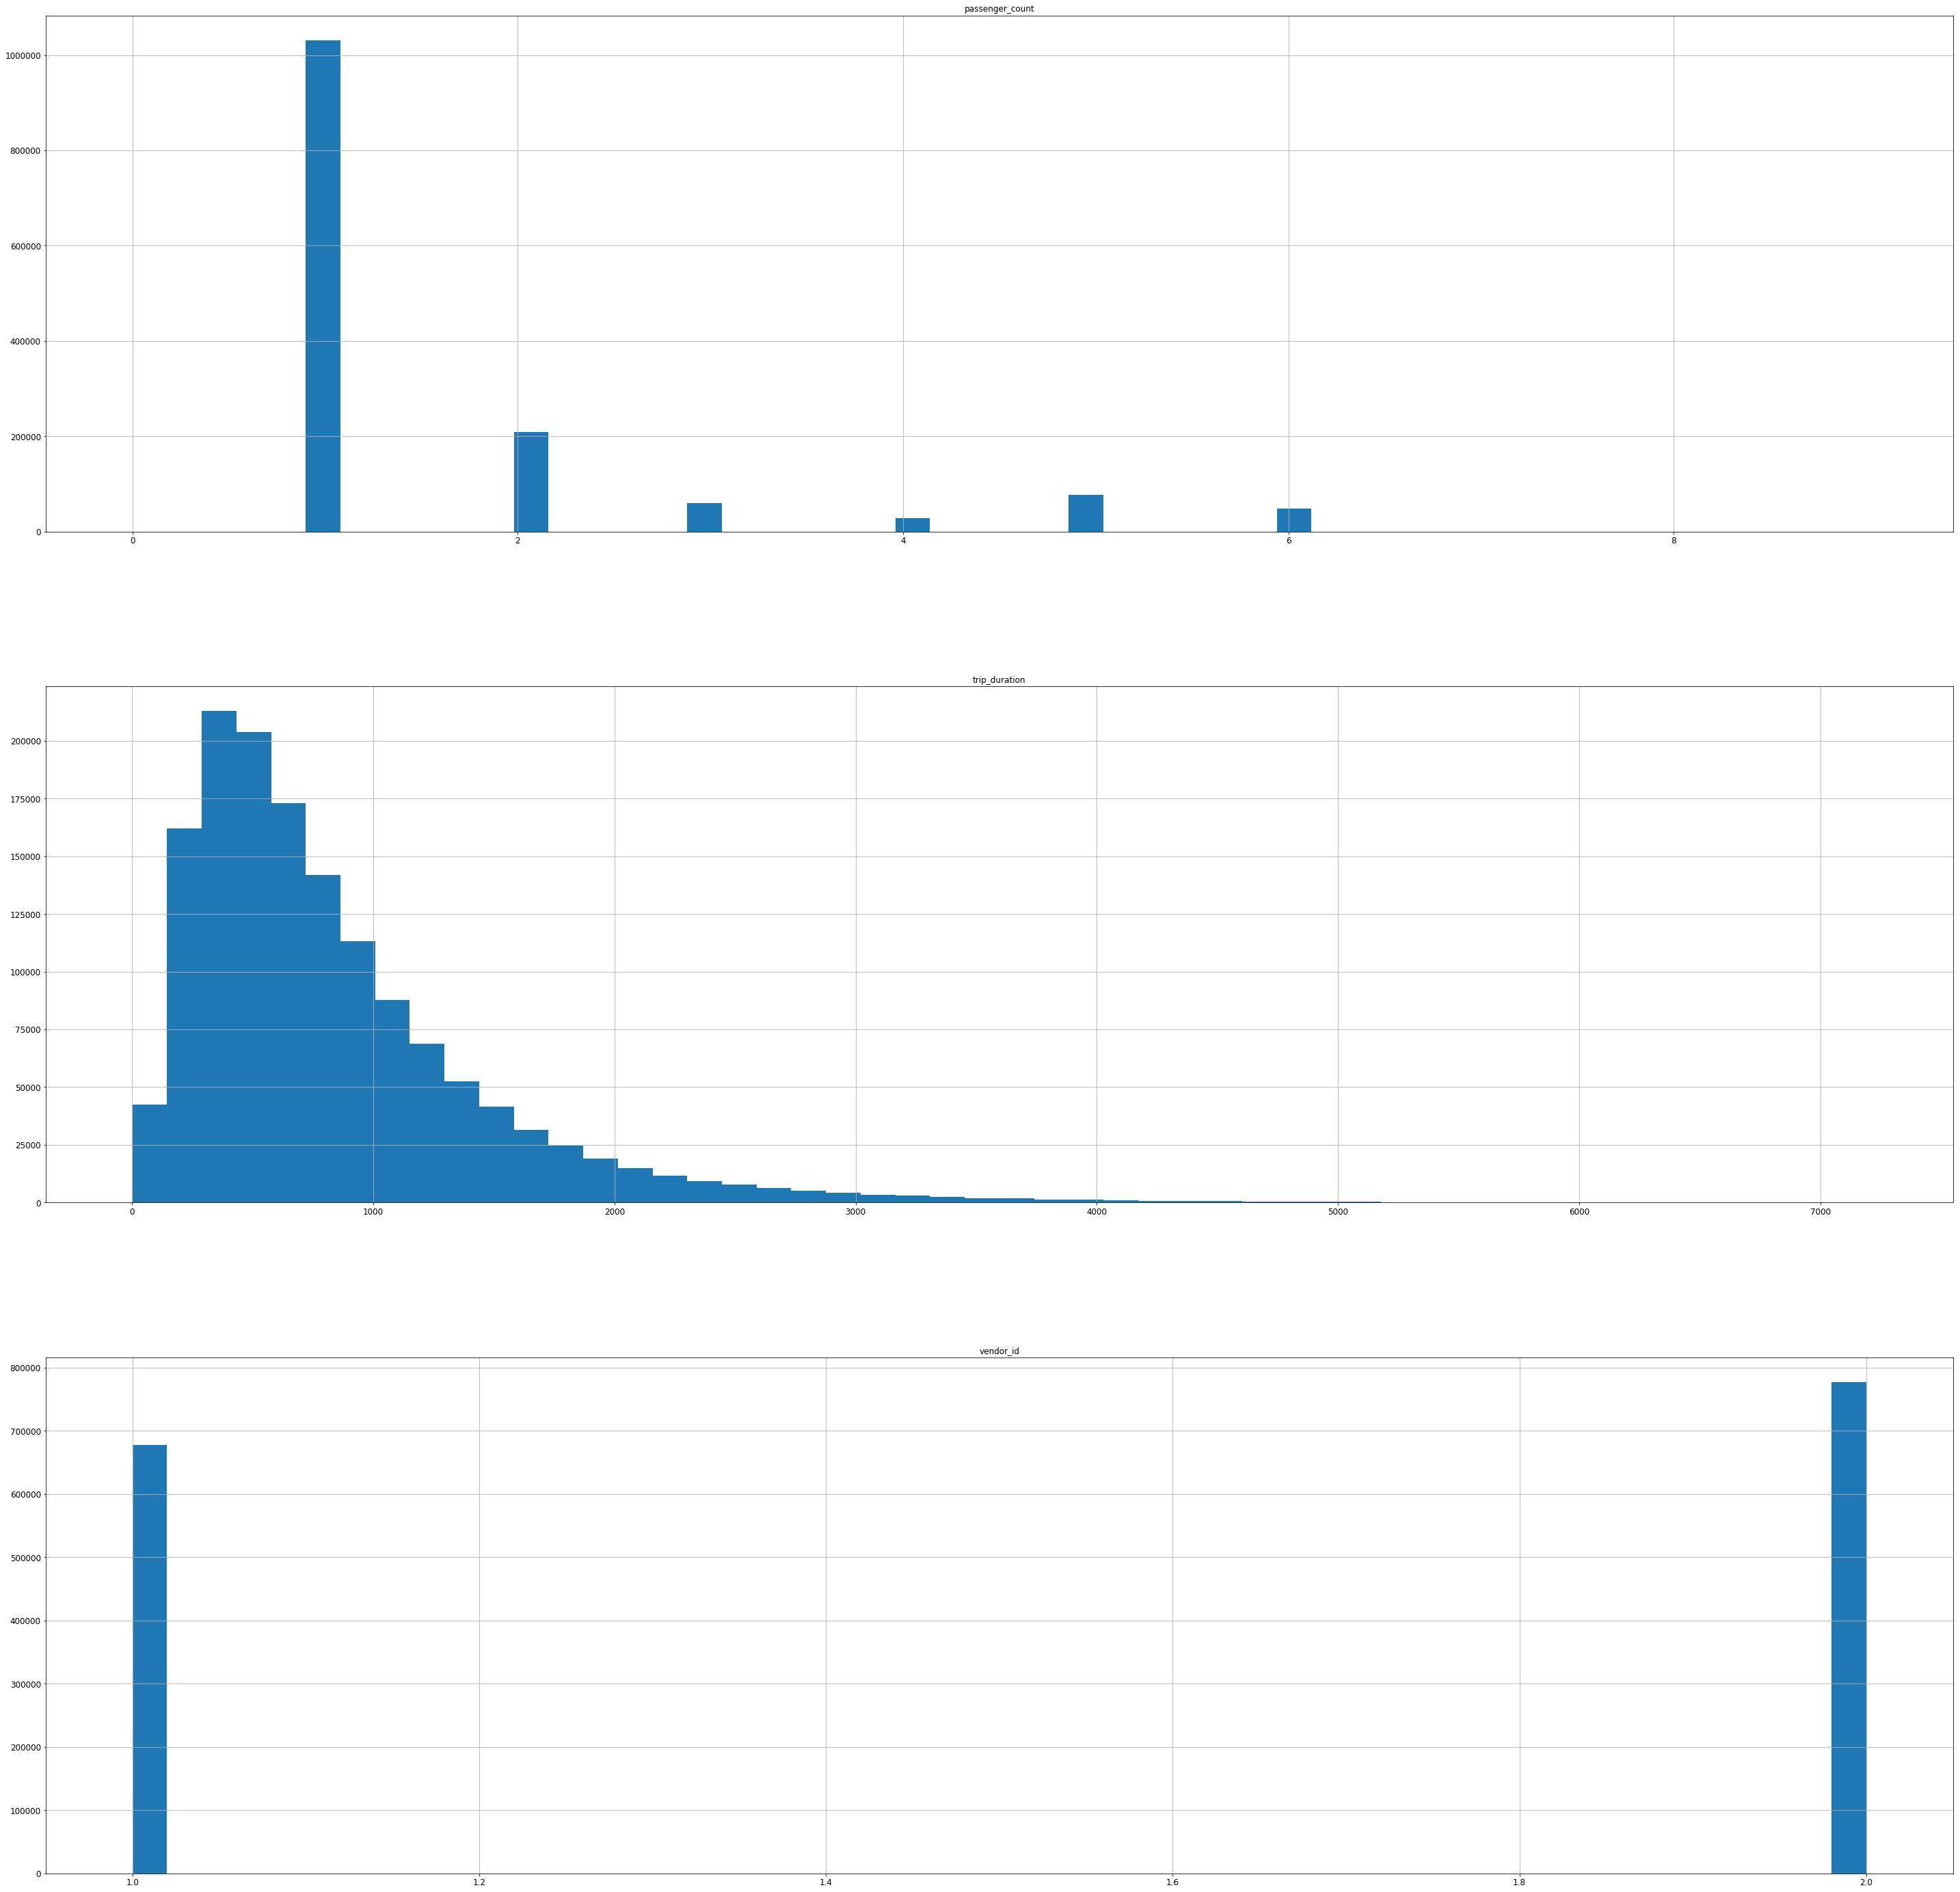

In [18]:
# Let's plot some histograms to have a previzualisation of some of the data ...
train_df_eda.drop(['id', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude'], 1).hist(bins=50, figsize=(50,50), layout=(3, 1))
plt.show()

Learning from EDA:

- Number of passengers is between 1 and 8, with a majority of 1
- There are two vendor_id, so we can suppose tha

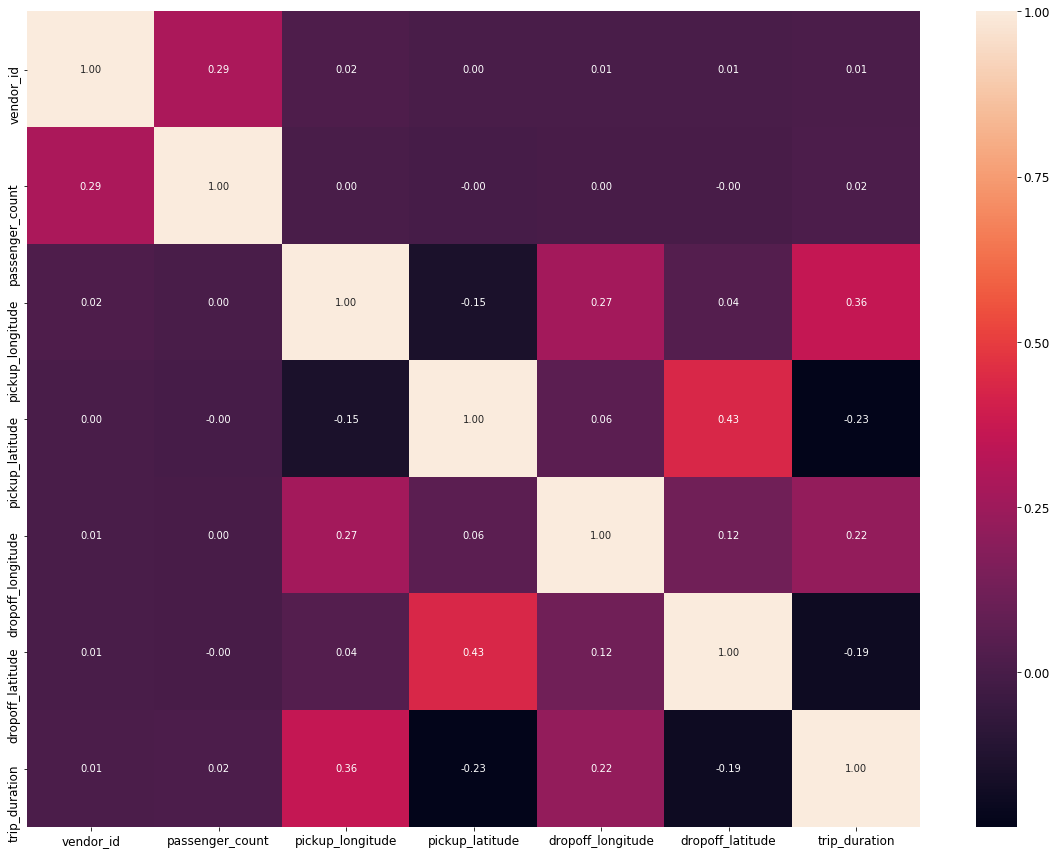

In [19]:
plt.figure(figsize=(20,15))  
sns.heatmap(train_df_eda.corr(), annot=True, fmt=".2f")
plt.show()

Variables doesn't seem to be strongly correlated within each others ...

In [20]:
new_date_cols = list()
for dt in train_df_eda['pickup_datetime']:
    date, time = dt.split(' ')
    datelist = list(map(int, date.split('-') + time.split(':')))
    datelist.append(datetime.datetime(*datelist).weekday())
    new_date_cols.append(datelist)
date_df = pd.DataFrame(new_date_cols, columns=['year','month', 'day', 'hours', 'minutes', 'seconds', 'weekday'], index=train_df_eda.index)
new_train_df_eda = train_df_eda.join(date_df)

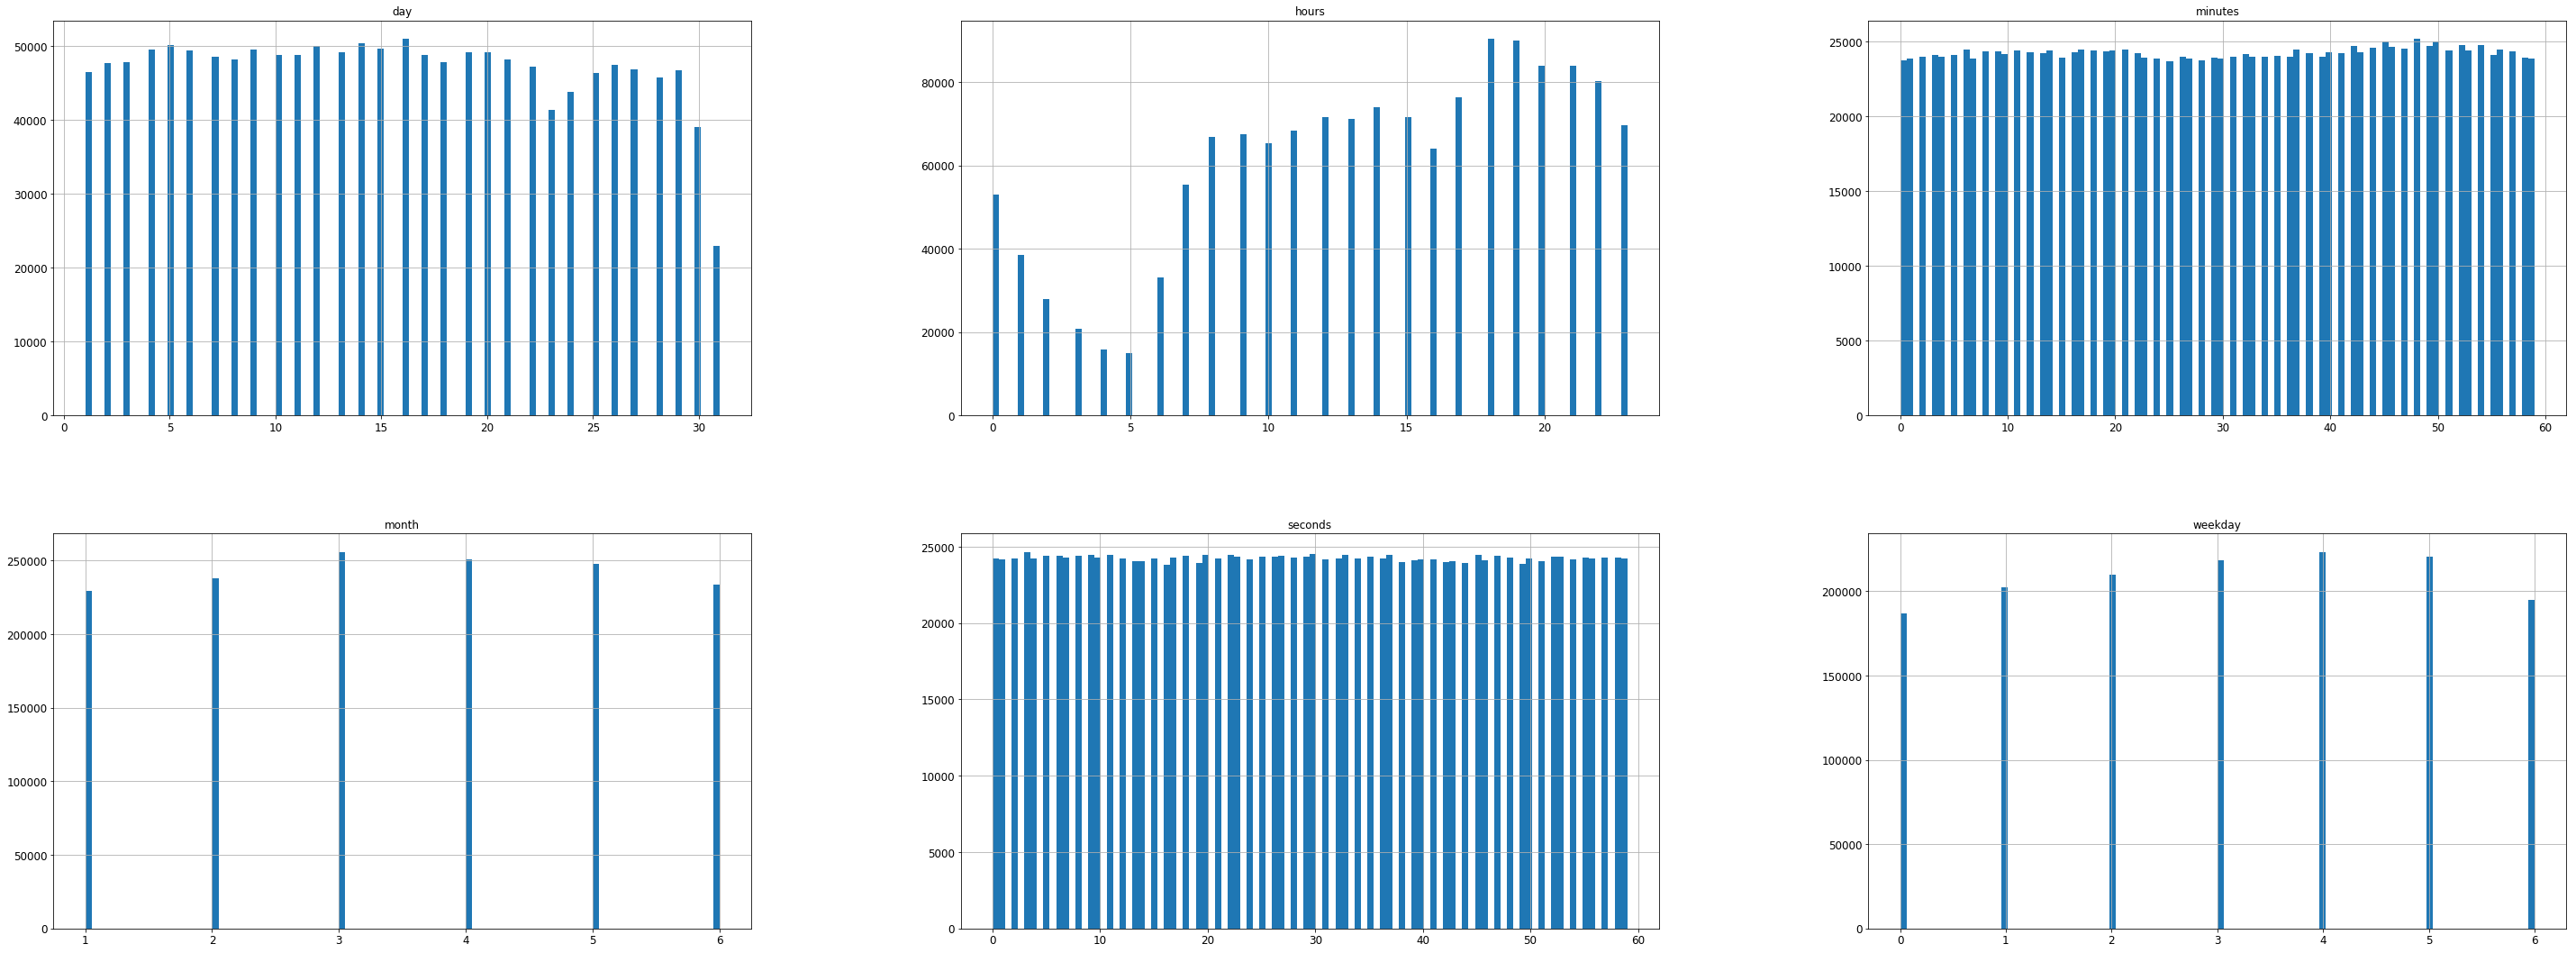

In [21]:
new_train_df_eda.drop(['id', 'pickup_longitude', 'pickup_latitude', 'dropoff_longitude', 'dropoff_latitude', 'pickup_datetime', 'pickup_datetime', 'vendor_id', 'passenger_count', 'trip_duration', 'year'], 1).hist(bins=100, figsize=(50,50), layout=(5, 3))
plt.show()

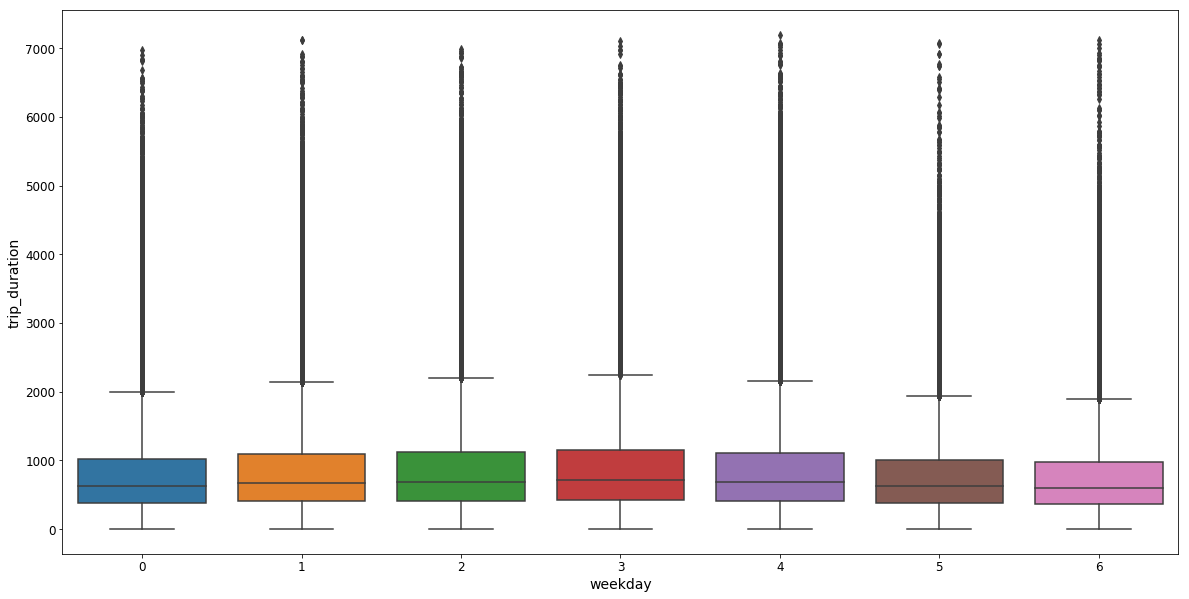

In [22]:
plt.figure(figsize=(20,10))
sns.boxplot('weekday', 'trip_duration', data=new_train_df_eda)
plt.show()

## 2. Features engineering

In [42]:
def format_nyctaxi_df(df, is_train=True):
    
    processed_df = df.copy()
    processed_df = processed_df.drop(['id'],  axis=1)
    
    if 'dropoff_datetime' in processed_df.columns.tolist():
        processed_df = processed_df.drop(['dropoff_datetime'],  axis=1)
    
    # TODO: fix this because its ugly
    if is_train:
        processed_df = processed_df[processed_df['trip_duration'] < 7200]
        processed_df = processed_df[processed_df['pickup_longitude'] > -74.258]
        processed_df = processed_df[processed_df['pickup_longitude'] < -73.695]
        processed_df = processed_df[processed_df['dropoff_longitude'] > -74.258]
        processed_df = processed_df[processed_df['dropoff_longitude'] < -73.695]
        processed_df = processed_df[processed_df['pickup_latitude'] < 40.921]
        processed_df = processed_df[processed_df['pickup_latitude'] > 40.500]
        processed_df = processed_df[processed_df['dropoff_latitude'] < 40.921]
        processed_df = processed_df[processed_df['dropoff_latitude'] > 40.500]
        processed_df = processed_df[processed_df['passenger_count'] > 0]
        processed_df = processed_df[processed_df['passenger_count'] < 7]
    
    # handle pickup_datetime column
    new_date_cols = list()
    for dt in processed_df['pickup_datetime']:
        date, time = dt.split(' ')
        datelist = list(map(int, date.split('-') + time.split(':')))
        datelist.append(datetime.datetime(*datelist).weekday())
        new_date_cols.append(datelist)
    date_df = pd.DataFrame(new_date_cols, columns=['year','month', 'day', 'hours', 'minutes', 'seconds', 'weekday'], index=processed_df.index)
    processed_df = processed_df.join(date_df)
    
    # handle store_and_fwd_flag column
    new_stored_cols = list()
    for stored in processed_df['store_and_fwd_flag']:
        new_stored_cols.append([0, 1] if stored == 'Y' else [1, 0])
    stored_df = pd.DataFrame(new_stored_cols, columns=['not_stored', 'stored'], index=processed_df.index)
    processed_df = processed_df.join(stored_df)
    
    processed_df = processed_df.drop(['pickup_datetime', 'store_and_fwd_flag'],  axis=1)
    
    return processed_df

def standardize(df):
    
    standardize_df = df.copy()
    
    target = None
    if 'trip_duration' in standardize_df.columns.tolist():
        target = standardize_df['trip_duration'] # Separating out the target before standardizing
        standardize_df = standardize_df.drop(['trip_duration'],  axis=1)

    # Standardizing the features
    scaled_values = StandardScaler().fit_transform(standardize_df.values)
    standardize_df = pd.DataFrame(scaled_values, index=standardize_df.index, columns=standardize_df.columns)
    if target is not None:
        standardize_df = standardize_df.join(target)
    
    return standardize_df

## 3. Cross validation

In [24]:
# Let's divide the train dataset in two datasets to evaluate perfomance of machine learning models used
train_df_cv = train_df_raw.copy()
train_df_cv = format_nyctaxi_df(train_df_cv)
Y_cv = train_df_cv['trip_duration']
X_cv = train_df_cv.drop(['trip_duration'], 1)

# Split dataset for prediction
x_train_cv, x_test_cv, y_train_cv, y_test_cv = sklearn.model_selection.train_test_split(X_cv, Y_cv, test_size=0.2, random_state=42)

x_train_cv = standardize(x_train_cv)
x_test_cv = standardize(x_test_cv)

x_train_cv.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,year,month,day,hours,minutes,seconds,weekday,not_stored,stored
432229,0.933840,-0.505447,0.143057,0.409037,-0.300704,0.305110,0.0,-0.307443,1.205585,-0.094782,1.580297,-1.297417,0.998345,0.074406,-0.074406
690478,0.933840,-0.505447,-0.854445,-0.543423,-0.146981,0.965549,0.0,0.881864,1.205585,-1.344893,-1.246514,-0.546912,-0.025171,0.074406,-0.074406
183859,0.933840,-0.505447,-0.473372,-0.222982,-0.339679,0.198198,0.0,0.287210,-0.632636,1.155329,1.637987,-0.951030,1.510104,0.074406,-0.074406
1018711,0.933840,-0.505447,-0.384535,-1.146944,1.482347,0.475619,0.0,-0.902096,-0.977303,0.686537,1.695677,-0.720106,1.510104,0.074406,-0.074406
305442,-1.070848,0.255989,2.703239,0.814566,-0.458999,-0.580726,0.0,0.881864,0.516252,-0.251046,1.291847,0.145862,0.486587,0.074406,-0.074406


In [25]:
# Create and train model on train data sample
model = RandomForestRegressor(random_state=42)
model.fit(x_train_cv, y_train_cv)

# Predict for test data sample
prediction = model.predict(x_test_cv)

In [26]:
mse = rmsle(y_test_cv, prediction)
mse

0.41260099612042117

## 4. Predict

In [37]:
# data for training
X_train = train_df_raw.copy()
X_train = format_nyctaxi_df(X_train)
Y_train = X_train['trip_duration']
X_train = X_train.drop(['trip_duration'], 1)
X_train = standardize(X_train)
X_train.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,year,month,day,hours,minutes,seconds,weekday,not_stored,stored
0,0.933578,-0.505534,-0.226962,0.606943,0.253955,0.433121,0.0,-0.307354,-0.172793,0.530338,-0.322746,1.473803,-1.560973,0.074433,-0.074433
1,-1.071147,-0.505534,-0.181141,-0.443034,-0.742450,-0.644401,0.0,1.477312,-0.402595,-2.126580,0.773945,0.319049,1.509712,0.074433,-0.074433
2,0.933578,-0.505534,-0.144566,0.464037,-0.909753,-1.303252,0.0,-1.497132,0.401713,-0.407398,0.312181,-0.316067,-1.049192,0.074433,-0.074433
3,0.933578,-0.505534,-0.961492,-1.107656,-1.108031,-1.408606,0.0,0.287535,-1.092002,0.842916,0.139019,0.088098,-0.537412,0.074433,-0.074433
4,0.933578,-0.505534,0.012791,1.510332,0.016850,0.962277,0.0,-0.307354,1.206021,-0.094819,0.023578,1.473803,0.997931,0.074433,-0.074433


In [45]:
# data to be predicted
X_test = test_df_raw.copy()
X_test = format_nyctaxi_df(X_test, is_train=False)
X_test = standardize(X_test)
X_test.head()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,year,month,day,hours,minutes,seconds,weekday,not_stored,stored
0,-1.072381,-0.504667,-0.197773,-0.633160,-0.230349,0.135761,0.0,1.475033,1.667379,1.468355,1.696525,1.647302,-0.024397,0.074277,-0.074277
1,-1.072381,-0.504667,0.128241,-2.376546,0.188104,-2.691303,0.0,1.475033,1.667379,1.468355,1.696525,1.358430,-0.024397,0.074277,-0.074277
2,-1.072381,-0.504667,-0.324602,-0.447076,-0.175046,-0.622304,0.0,1.475033,1.667379,1.468355,1.696525,1.011784,-0.024397,0.074277,-0.074277
3,0.932505,-0.504667,0.239060,0.702656,-0.178726,-0.595896,0.0,1.475033,1.667379,1.468355,1.696525,0.665138,-0.024397,0.074277,-0.074277
4,-1.072381,-0.504667,0.046321,0.353366,0.164658,0.113719,0.0,1.475033,1.667379,1.468355,1.696525,0.202944,-0.024397,0.074277,-0.074277


In [46]:
# Create and train model on train data sample
model_final = RandomForestRegressor(random_state=42)
model_final.fit(X_train, Y_train)

# Predict for test data sample
prediction_final = model_final.predict(X_test)

In [49]:
result_df = test_df_raw.copy()
result_df['trip_duration'] = prediction_final

result_df.head()
result_df.to_csv('submission.csv', columns=['id', 'trip_duration'], index=False)